![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import sqlalchemy
import sqlite3
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect('zippedData/im.db')
cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [4]:
df_movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
df_movie_basics.head()
# this will be our master table and will left join on this set

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
df_movie_akas = pd.read_sql("SELECT * FROM movie_akas;", conn)
df_movie_akas = df_movie_akas[df_movie_akas['is_original_title'] == 1.0]
df_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
38,tt0369610,45,Jurassic World,None,None,original,None,1.0
80,tt0401729,7,John Carter,None,None,original,None,1.0
83,tt10010134,1,Versailles Rediscovered - The Sun King's Vanis...,None,None,original,None,1.0
86,tt10027708,1,Miguelito - Canto a Borinquen,None,None,original,None,1.0
90,tt10050722,1,Thing I Don't Get,None,None,original,None,1.0


In [6]:
df_movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
df_movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [7]:
# `movie_basics` `movie_ratings` and 'movie_akas' are our initial three and can add more data in later as we see fit
# So we are going to do a merge over these three
# Before doing so, also going to import in the 'bom.movie_gross.csv.gz' file and take a look at contents. 

In [8]:
df_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv')
df_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [9]:
df_movie_basics = df_movie_basics[(df_movie_basics['start_year'] >= 2010) & (df_movie_basics['start_year'] <= 2018)]
#only choose years 2010 - 2018

In [10]:
merged_df = pd.merge(df_movie_basics, df_movie_ratings, on='movie_id', how='left')
## do a left join pulling in df_movie_ratings

In [11]:
#pull in movie budgets
df_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')
df_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
df_movie_budgets['year'] = df_movie_budgets['release_date'].str[-4:]
df_movie_budgets['year'] = pd.to_numeric(df_movie_budgets['year'], downcast='integer')
# create new column for 'year' in df_movie_budgets to key off + 'title' to join with merged_df

In [13]:
merged_df = merged_df.merge(df_movie_budgets, how = 'left', left_on = ['primary_title', 'start_year'], right_on = ['movie', 'year'])

In [14]:
#dropna for any without production budgets
merged_df = merged_df.dropna(subset=['production_budget'])

In [15]:
# drop useless columns
merged_df.drop(columns=['movie','year'],
               axis='columns', inplace=True)
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
19,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248.0,26.0,"Dec 31, 2012","$45,000,000",$0,"$73,706"
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,37.0,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,67.0,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587"
56,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0,34.0,"Jun 12, 2015","$215,000,000","$652,270,625","$1,648,854,864"
58,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787.0,16.0,"Oct 28, 2011","$45,000,000","$13,109,815","$21,544,732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127625,tt8408152,Detention,Detention,2012,NaN,Horror,NaN,NaN,45.0,"Apr 13, 2012","$10,000,000",$0,$0
129399,tt8632862,Fahrenheit 11/9,Fahrenheit 11/9,2018,128.0,Documentary,6.7,11628.0,29.0,"Sep 21, 2018","$5,000,000","$6,352,306","$6,653,715"
131109,tt8852552,Icarus,Icarus,2010,78.0,Thriller,NaN,NaN,91.0,"Feb 9, 2010","$6,000,000",$0,$0
134493,tt9347476,Believe,Believe,2016,NaN,None,NaN,NaN,13.0,"Dec 2, 2016","$3,500,000","$890,303","$890,303"


In [16]:
# convert release date to datetime then add release_month column
merged_df['release_date'] =  pd.to_datetime(merged_df['release_date'])
merged_df['release_month'] = merged_df['release_date'].dt.month

In [17]:
#drop rows with null values and inspect info
merged_df.dropna(inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 19 to 129399
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           1457 non-null   object        
 1   primary_title      1457 non-null   object        
 2   original_title     1457 non-null   object        
 3   start_year         1457 non-null   int64         
 4   runtime_minutes    1457 non-null   float64       
 5   genres             1457 non-null   object        
 6   averagerating      1457 non-null   float64       
 7   numvotes           1457 non-null   float64       
 8   id                 1457 non-null   float64       
 9   release_date       1457 non-null   datetime64[ns]
 10  production_budget  1457 non-null   object        
 11  domestic_gross     1457 non-null   object        
 12  worldwide_gross    1457 non-null   object        
 13  release_month      1457 non-null   int64         
dtypes: da

In [18]:
# convert runtime_minutes and numvotes from float to int
merged_df = merged_df.astype({"runtime_minutes" : "int", "numvotes": "int"})
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_month
19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,2012-12-31,"$45,000,000",$0,"$73,706",12
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,2013-12-25,"$91,000,000","$58,236,838","$187,861,183",12
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,2014-09-19,"$28,000,000","$26,017,685","$62,108,587",9
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,2015-06-12,"$215,000,000","$652,270,625","$1,648,854,864",6
58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,2011-10-28,"$45,000,000","$13,109,815","$21,544,732",10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121683,tt7784604,Hereditary,Hereditary,2018,127,"Drama,Horror,Mystery",7.3,151571,56.0,2018-06-08,"$10,000,000","$44,069,456","$70,133,905",6
121697,tt7785302,Spotlight,Spotlight,2015,99,Drama,8.0,12,34.0,2015-11-06,"$20,000,000","$45,055,776","$92,088,460",11
123478,tt7959026,The Mule,The Mule,2018,116,"Crime,Drama,Thriller",7.1,58955,100.0,2018-12-14,"$50,000,000","$103,804,407","$170,857,676",12
124315,tt8043306,Teefa in Trouble,Teefa in Trouble,2018,155,"Action,Comedy,Crime",7.4,2724,8.0,2018-07-20,"$1,500,000",$0,"$98,806",7


In [19]:
# convert runtime_minutes and numvotes from float to int
merged_df = merged_df.astype({"runtime_minutes" : "int", "numvotes": "int"})
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_month
19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,2012-12-31,"$45,000,000",$0,"$73,706",12
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,2013-12-25,"$91,000,000","$58,236,838","$187,861,183",12
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,2014-09-19,"$28,000,000","$26,017,685","$62,108,587",9
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,2015-06-12,"$215,000,000","$652,270,625","$1,648,854,864",6
58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,2011-10-28,"$45,000,000","$13,109,815","$21,544,732",10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121683,tt7784604,Hereditary,Hereditary,2018,127,"Drama,Horror,Mystery",7.3,151571,56.0,2018-06-08,"$10,000,000","$44,069,456","$70,133,905",6
121697,tt7785302,Spotlight,Spotlight,2015,99,Drama,8.0,12,34.0,2015-11-06,"$20,000,000","$45,055,776","$92,088,460",11
123478,tt7959026,The Mule,The Mule,2018,116,"Crime,Drama,Thriller",7.1,58955,100.0,2018-12-14,"$50,000,000","$103,804,407","$170,857,676",12
124315,tt8043306,Teefa in Trouble,Teefa in Trouble,2018,155,"Action,Comedy,Crime",7.4,2724,8.0,2018-07-20,"$1,500,000",$0,"$98,806",7


In [20]:
import re
merged_df['worldwide_gross'] = merged_df['worldwide_gross'].replace( '[^0-9]', '', regex=True)
merged_df['domestic_gross'] = merged_df['domestic_gross'].replace( '[^0-9]', '', regex=True)
merged_df['production_budget'] = merged_df['production_budget'].replace( '[^0-9]', '', regex=True)
merged_df['production_budget'] = merged_df['production_budget'].astype(int)
merged_df['domestic_gross'] = merged_df['domestic_gross'].astype(int)
merged_df['worldwide_gross'] = merged_df['worldwide_gross'].astype(int)
#get rid of dollar signs and turn to integer 

In [21]:
merged_df['profitability_index'] = merged_df['worldwide_gross'] / merged_df['production_budget']
merged_df.head()
#create profitability index which relates gross profit over budget

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_month,profitability_index
19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,2012-12-31,45000000,0,73706,12,0.001638
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,2013-12-25,91000000,58236838,187861183,12,2.064409
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,2014-09-19,28000000,26017685,62108587,9,2.218164
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,2015-06-12,215000000,652270625,1648854864,6,7.669092
58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,2011-10-28,45000000,13109815,21544732,10,0.478772


In [22]:
merged_df.reset_index()

,index,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_month,profitability_index
0,19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,2012-12-31,45000000,0,73706,12,0.001638
1,50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,2013-12-25,91000000,58236838,187861183,12,2.064409
2,54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,2014-09-19,28000000,26017685,62108587,9,2.218164
3,56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,2015-06-12,215000000,652270625,1648854864,6,7.669092
4,58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,2011-10-28,45000000,13109815,21544732,10,0.478772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,121683,tt7784604,Hereditary,Hereditary,2018,127,"Drama,Horror,Mystery",7.3,151571,56.0,2018-06-08,10000000,44069456,70133905,6,7.013390
1453,121697,tt7785302,Spotlight,Spotlight,2015,99,Drama,8.0,12,34.0,2015-11-06,20000000,45055776,92088460,11,4.604423
1454,123478,tt7959026,The Mule,The Mule,2018,116,"Crime,Drama,Thriller",7.1,58955,100.0,2018-12-14,50000000,103804407,170857676,12,3.417154
1455,124315,tt8043306,Teefa in Trouble,Teefa in Trouble,2018,155,"Action,Comedy,Crime",7.4,2724,8.0,2018-07-20,1500000,0,98806,7,0.065871


In [23]:
merged_df[['genre1', 'genre2', 'genre3']] = merged_df['genres'].str.split(',', expand=True)
#split genre column out into 3 columns

In [24]:
merged_df.worldwide_gross.describe() #160,000,000 is the top quartile in earned

count    1.457000e+03
mean     1.419639e+08
std      2.352410e+08
min      0.000000e+00
25%      8.217571e+06
50%      5.246054e+07
75%      1.599465e+08
max      2.048134e+09
Name: worldwide_gross, dtype: float64

In [25]:
merged_df.profitability_index.describe()  # 4 is the top quartile in profability index

count    1457.000000
mean        3.691895
std        12.182487
min         0.000000
25%         0.744915
50%         2.135069
75%         4.004564
max       416.564740
Name: profitability_index, dtype: float64

In [26]:
#create new dataframe that only has top quartile in both profitability index and earned worldwide revenue
over_100_gross = merged_df.loc[(merged_df['worldwide_gross'] > 160000000) & (merged_df['profitability_index'] > 4)]
over_100_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 56 to 112595
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_id             179 non-null    object        
 1   primary_title        179 non-null    object        
 2   original_title       179 non-null    object        
 3   start_year           179 non-null    int64         
 4   runtime_minutes      179 non-null    int64         
 5   genres               179 non-null    object        
 6   averagerating        179 non-null    float64       
 7   numvotes             179 non-null    int64         
 8   id                   179 non-null    float64       
 9   release_date         179 non-null    datetime64[ns]
 10  production_budget    179 non-null    int64         
 11  domestic_gross       179 non-null    int64         
 12  worldwide_gross      179 non-null    int64         
 13  release_month        179 non-nu

In [27]:
merged_df['production_budget'].describe()
# budgets of 5.500000e+07 are top quartile and can be considered high budget

count    1.457000e+03
mean     4.439851e+07
std      5.569060e+07
min      1.500000e+04
25%      8.000000e+06
50%      2.300000e+07
75%      5.500000e+07
max      4.106000e+08
Name: production_budget, dtype: float64

In [28]:
high_budget_df = merged_df.loc[(merged_df['production_budget'] > 5.500000e+07)]

In [29]:
# melt the dataframe to convert the genre columns to rows
genres_pi = merged_df.melt(id_vars=['profitability_index'], value_vars=['genre1', 'genre2', 'genre3'])
genres__pi_top_100 = over_100_gross.melt(id_vars=['profitability_index'], value_vars=['genre1', 'genre2', 'genre3'])
genres_pi_high_budget = high_budget_df.melt(id_vars=['profitability_index'], value_vars=['genre1', 'genre2', 'genre3'])

# group the dataframe by the 'value' column, which is the new column created by the melt function
genres_pi = genres_pi.groupby('value').agg({'profitability_index': ['mean']}).reset_index()
genres__pi_top_100 = genres__pi_top_100.groupby('value').agg({'profitability_index': ['mean']}).reset_index()
genres_pi_high_budget = genres_pi_high_budget.groupby('value').agg({'profitability_index': ['mean']}).reset_index()

# rename the columns of the dataframe
genres_pi.columns = ['genre', 'average_profitability_index']
genres__pi_top_100.columns = ['genre', 'average_profitability_index']
genres_pi_high_budget.columns = ['genre', 'average_profitability_index']

#do the same for worldwide_gross
genres_gross = merged_df.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])
genres_gross_top_100 = over_100_gross.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])
genres_gross_high_budget = high_budget_df.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])

# group the dataframe by the 'value' column, which is the new column created by the melt function
genres_gross = genres_gross.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()
genres_gross_top_100 = genres_gross_top_100.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()
genres_gross_high_budget = genres_gross_high_budget.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()

# rename the columns of the dataframe
genres_gross.columns = ['genre', 'average_gross']
genres_gross_top_100.columns = ['genre', 'average_gross']
genres_gross_high_budget.columns = ['genre', 'average_gross']


<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

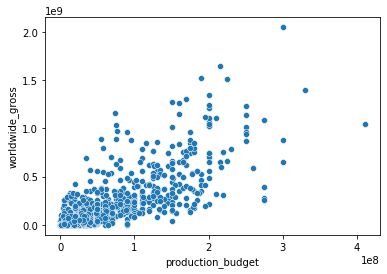

In [30]:
sns.scatterplot(x='production_budget', y='worldwide_gross', data=merged_df)

<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

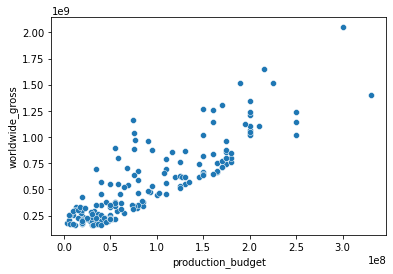

In [31]:
sns.scatterplot(x='production_budget', y='worldwide_gross', data=over_100_gross)

Text(0.5, 1.0, 'Production Budget vs. Profitability Index for All Films')

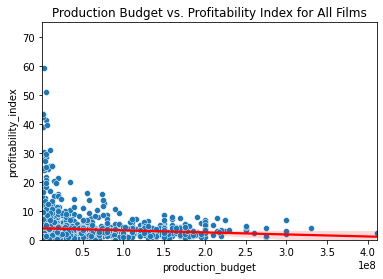

In [32]:
sns.scatterplot(x='production_budget', y='profitability_index', data=merged_df, zorder=1)
plt.ylim(0, 75)
sns.regplot(x='production_budget', y='profitability_index', data=merged_df, color='red', scatter=False)
plt.title('Production Budget vs. Profitability Index for All Films')

Text(0.5, 1.0, 'Production Budget vs. Profitability Index for High Grossing Films')

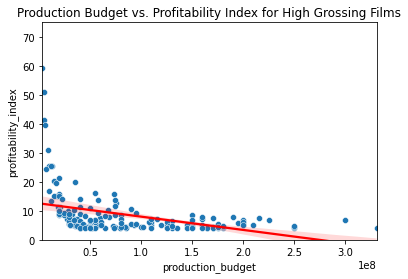

In [33]:
sns.scatterplot(x='production_budget', y='profitability_index', data=over_100_gross, zorder=1)
plt.ylim(0, 75)
sns.regplot(x='production_budget', y='profitability_index', data=over_100_gross , color='red', scatter=False)
plt.title('Production Budget vs. Profitability Index for High Grossing Films')

(0.0, 30.0)

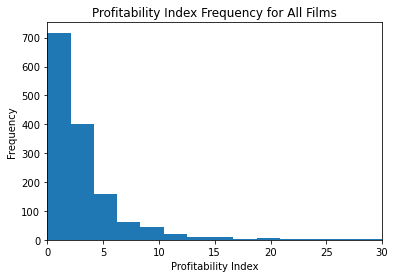

In [34]:
plt.hist(merged_df['profitability_index'],bins=200)
plt.xlabel('Profitability Index')
plt.ylabel('Frequency')
plt.title('Profitability Index Frequency for All Films')
plt.xlim(0,30)

#need to compare this to profitability ratio of only 160 million and up budgets to show they are pretty much the same

(0.0, 30.0)

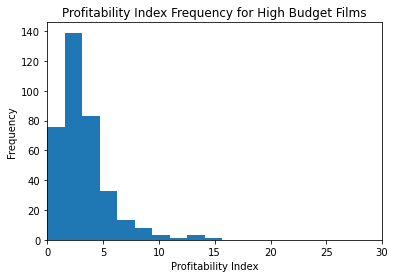

In [36]:
plt.hist(high_budget_df['profitability_index'],bins=10)
plt.xlabel('Profitability Index')
plt.ylabel('Frequency')
plt.title('Profitability Index Frequency for High Budget Films')
plt.xlim(0,30)

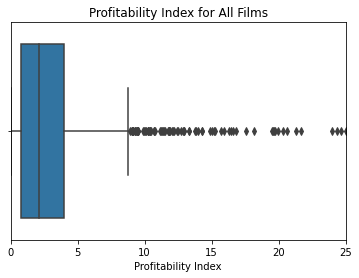

In [151]:
sns.boxplot(x=merged_df['profitability_index'])
plt.xlim(0, 25)
plt.xlabel('Profitability Index')
plt.title('Profitability Index for All Films')
plt.show()

#need to compare this to profitability ratio of only 160 million and up budgets to show they are pretty much the same

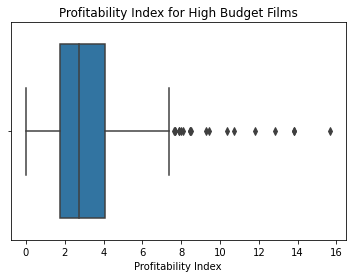

In [150]:
sns.boxplot(x=high_budget_df['profitability_index'])
plt.xlabel('Profitability Index')
plt.title('Profitability Index for High Budget Films')
plt.show()

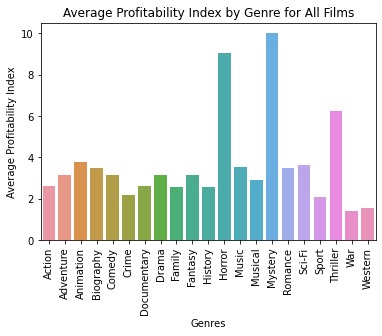

In [139]:
# so from the graphs above, we have proven that profitability index is generally the same for all films vs. high budget
# and bigger bets will make us more money, especially for a company like Microsoft. 
# So if we go high budget, what kind of films to make?

sns.barplot(x='genre', y='average_profitability_index', data=genres_pi)
plt.xlabel('Genres')
plt.ylabel('Average Profitability Index')
plt.title('Average Profitability Index by Genre for All Films')
plt.xticks(rotation=90)
plt.show()

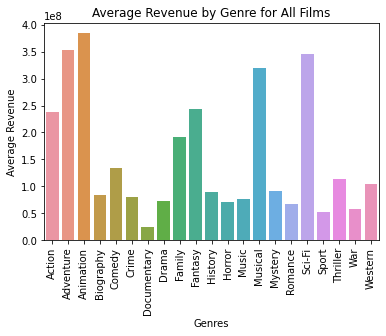

In [140]:
sns.barplot(x='genre', y='average_gross', data=genres_gross)
plt.xlabel('Genres')
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Genre for All Films')
plt.xticks(rotation=90)
plt.show()

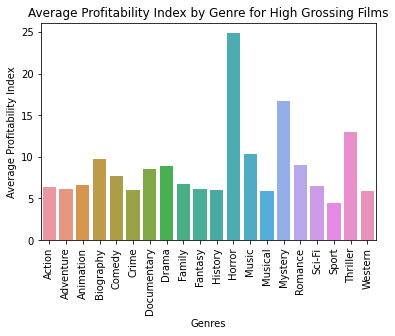

In [141]:
sns.barplot(x='genre', y='average_profitability_index', data=genres__pi_top_100)
plt.xlabel('Genres')
plt.ylabel('Average Profitability Index')
plt.title('Average Profitability Index by Genre for High Grossing Films')
plt.xticks(rotation=90)
plt.show()

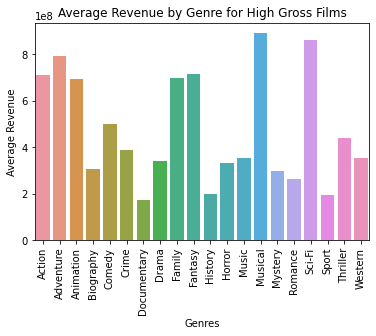

In [142]:
sns.barplot(x='genre', y='average_gross', data=genres_gross_top_100)
plt.xlabel('Genres')
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Genre for High Gross Films')
plt.xticks(rotation=90)
plt.show()

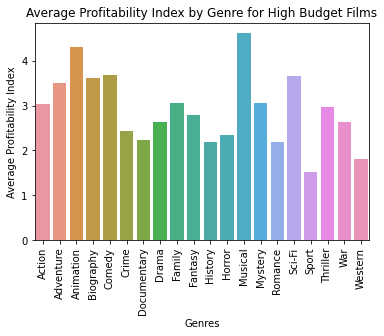

In [143]:
sns.barplot(x='genre', y='average_profitability_index', data=genres_pi_high_budget)
plt.xlabel('Genres')
plt.ylabel('Average Profitability Index')
plt.title('Average Profitability Index by Genre for High Budget Films')
plt.xticks(rotation=90)
plt.show()

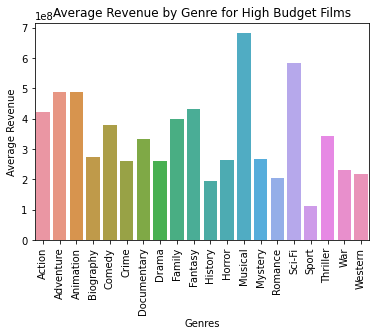

In [144]:
sns.barplot(x='genre', y='average_gross', data=genres_gross_high_budget)
plt.xlabel('Genres')
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Genre for High Budget Films')
plt.xticks(rotation=90)
plt.show()
# add counts for each one as an overlay

In [53]:
merged_principals_df =pd.read_csv('zippedData/merged_principals.csv') 

In [54]:
directors_df = merged_principals_df.loc[merged_principals_df['category'] == 'director']

In [55]:
scifi_high_budget_df = high_budget_df[high_budget_df['genre1'].isin(['Sci-Fi']) | high_budget_df['genre2'].isin(['Sci-Fi']) | high_budget_df['genre3'].isin(['Sci-Fi'])]

In [56]:
scifi_merge = pd.merge(directors_df, scifi_high_budget_df, on='movie_id')
scifi_average_profitability = scifi_merge.groupby('primary_name').mean()['profitability_index'].sort_values(ascending=False)
scifi_average_profitability

primary_name
Gary Ross             8.474042
J.A. Bayona           7.681016
Colin Trevorrow       7.669092
Ruben Fleischer       7.358867
Ryan Coogler          6.741291
Alfonso Cuarón        6.306352
Francis Lawrence      5.613867
Joss Whedon           5.495112
Joe Russo             5.196585
Anthony Russo         5.196585
Wes Ball              5.091249
Rupert Wyatt          5.064368
Jon Watts             5.029522
Christopher Nolan     4.630346
Michael Bay           4.599556
Travis Knight         4.560741
Gareth Edwards        4.276120
James Mangold         4.233758
Shane Black           3.944660
Ridley Scott          3.915299
Steven Spielberg      3.861934
Paul W.S. Anderson    3.702271
Jon Favreau           3.653861
Brad Peyton           3.567136
Marc Webb             3.494969
Bryan Singer          3.393639
Jon Turteltaub        2.974892
Zack Snyder           2.968887
Morten Tyldum         2.747633
Chris Columbus        2.711576
Jon M. Chu            2.683862
Joe Johnston          2.64

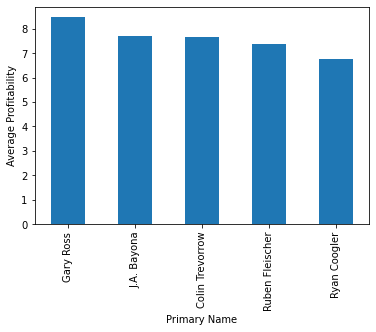

In [59]:
top_5_scifi = scifi_average_profitability.head(5)
top_5_scifi.plot.bar()
plt.xlabel('Primary Name')
plt.ylabel('Average Profitability')
plt.show()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***